# 畳み込み演算


### 畳み込み演算の特徴
+ 線形変換
+ 全結合に比べて疎結合
+ パラメータがすべて共通
+ パラメータ数が少ない
+ 移動不変性を獲得できる (画像全体に渡る同一カーネルの重みを使用)
+ 局所性のある特徴量を獲得できる (移動させたカーネルと画像のスカラ積)

In [2]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [4]:
from torchvision import datasets, transforms
data_path = "C:\\Users\\inoue\\Documents\\AI_Learning_Dataset\\"
cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ])
)

Files already downloaded and verified


In [5]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [6]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [7]:
conv = nn.Conv2d(
    in_channels=3,
    out_channels=16,
    kernel_size=3
)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [8]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [9]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

In [10]:
# img.shape
# img = img.mean(dim=0)
# img.shape

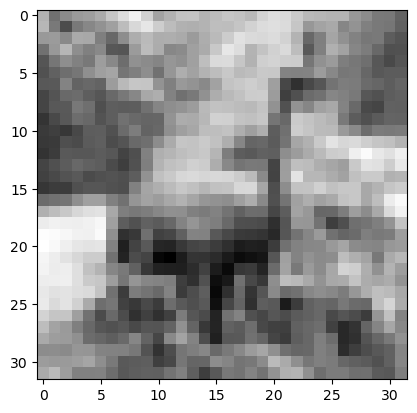

In [11]:
plt.imshow(img.mean(dim=0), cmap='gray')
plt.show()

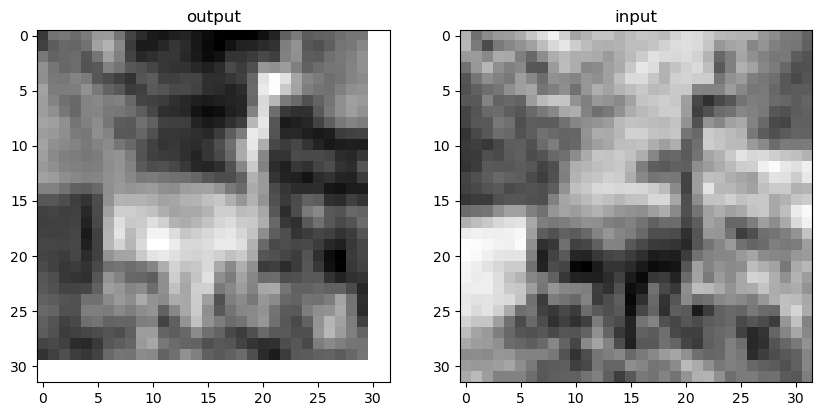

In [12]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(dim=0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.show()

#### 畳み込み演算にPaddingを追加することで特徴量マップのサイズを同じにできる

In [13]:
# 微分カーネル
conv = nn.Conv2d(
    in_channels=3,
    out_channels=1,
    kernel_size=3,
    padding=1 # パディング
)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()


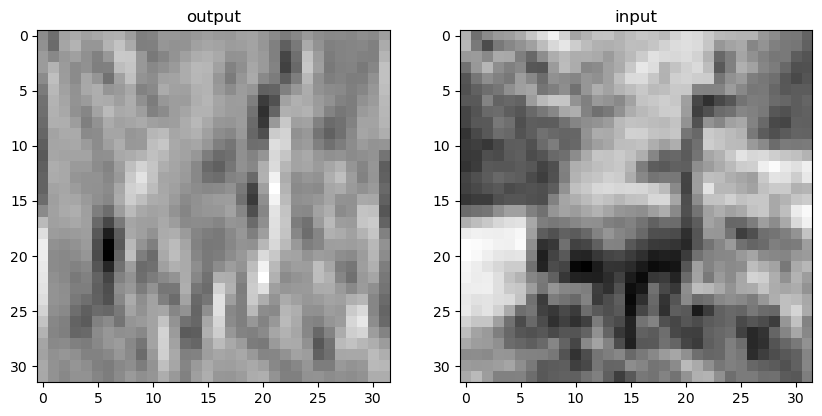

In [14]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.show()

In [15]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

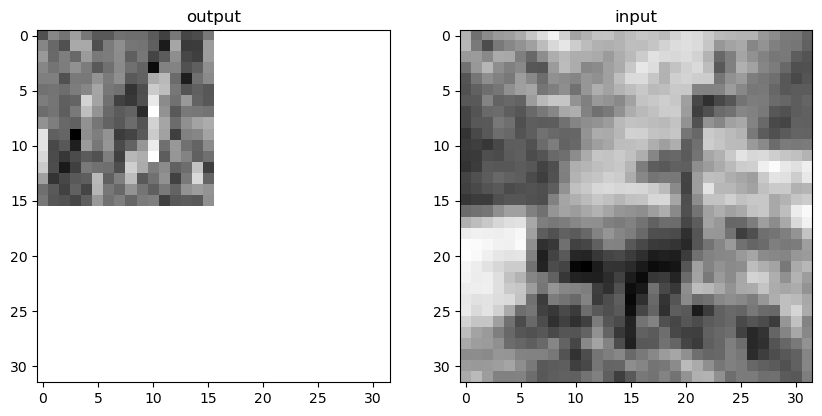

In [16]:
output = pool(conv(img.unsqueeze(0)))

plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.show()

In [17]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... <1>
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [18]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [47]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

# nn.Moduleによるモデルの作成

Module APIは, 独自なモデルを作成できる

In [30]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            padding=1
        )
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=8,
            kernel_size=3,
            padding=1
        )
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8) # (N,8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [31]:
model_module = Net1()

numel_list = [p.numel() for p in model_module.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [32]:
model_module

Net1(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): Tanh()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): Tanh()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

# Functional APIによるモデルの作成

In [34]:
import torch.nn.functional as F

class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [35]:
model_functional = Net2()
model_functional

Net2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [36]:
model = Net1() # module API
model(img.unsqueeze(0))

tensor([[ 0.0107, -0.2235]], grad_fn=<AddmmBackward0>)

訓練ループ

In [37]:
# 初期設定
# GPUが使えるか確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス: ", device)

# ネットワークがある程度固定であれば、高速化される
torch.backends.cudnn.benchmark = True

使用デバイス:  cuda:0


In [38]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            # modelとlossをGPUに転送
            outputs = outputs.to('cuda:0')
            loss = loss.to('cuda:0')

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(),
                epoch,
                loss_train / len(train_loader)
            ))

In [43]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            padding=1
        )
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=8,
            kernel_size=3,
            padding=1
        )
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8) # (N,8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        out = self.logsoftmax(out) # LogSoftmax
        return out

In [44]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = ConvNet()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.NLLLoss()

In [46]:
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2023-03-16 19:40:04.119810 Epoch 1, Training loss 0.36839824003778443
2023-03-16 19:40:21.512985 Epoch 10, Training loss 0.30991732779961484
2023-03-16 19:40:40.894189 Epoch 20, Training loss 0.28116536074003595
2023-03-16 19:41:02.223112 Epoch 30, Training loss 0.25993987998575163
2023-03-16 19:41:25.830467 Epoch 40, Training loss 0.2383572134622343
2023-03-16 19:41:48.110757 Epoch 50, Training loss 0.22344310605412077
2023-03-16 19:42:09.519745 Epoch 60, Training loss 0.20643974603361384
2023-03-16 19:42:32.567959 Epoch 70, Training loss 0.19053546813832725
2023-03-16 19:42:52.753422 Epoch 80, Training loss 0.17886888292754533
2023-03-16 19:43:12.402503 Epoch 90, Training loss 0.16501391607864646
2023-03-16 19:43:34.921693 Epoch 100, Training loss 0.15056856365720178
